# Geolife Dataset

This aims at performing EDA on the geolife dataset. 

In [3]:
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import osmnx as ox
import os
import glob
from tqdm import tqdm
import numpy as np
from scipy.stats import gaussian_kde
import pickle
# import pptk

/tmp/ipykernel_1358228/3191411373.py:2: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  beijing_road = ox.graph_from_bbox(40.05, 39.83, 116.62, 116.17, network_type='drive')
/tmp/ipykernel_1358228/3191411373.py:2: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  beijing_road = ox.graph_from_bbox(40.05, 39.83, 116.62, 116.17, network_type='drive')


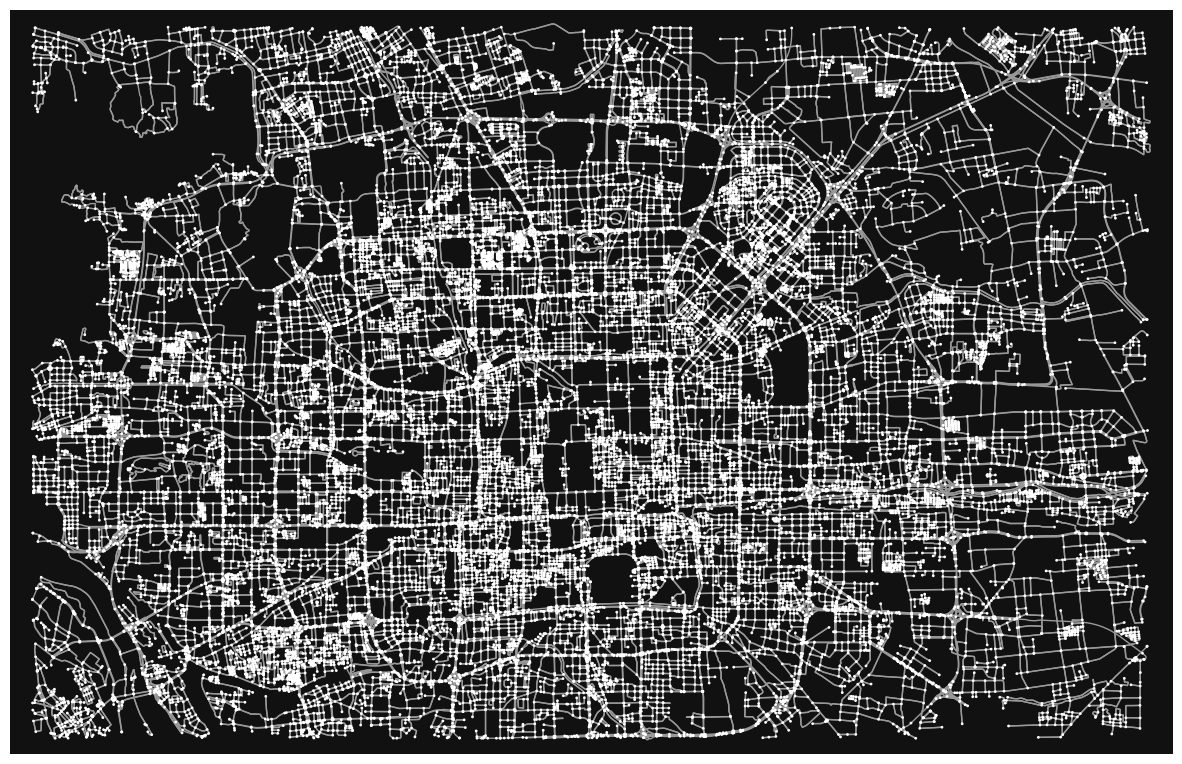

In [3]:
# Using OSMnx to download the road network of Beijing
beijing_road = ox.graph_from_bbox(40.05, 39.83, 116.62, 116.17, network_type='drive')
fig, ax = ox.plot_graph(beijing_road, figsize=(15,15), show=False, close=False, node_size=4)

plt.show()

Beijing OSM vs OSMnx

<div style="text-align: center;">
    <table>
        <tr>
            <td><img src="../imgs/geolife_osm_core.png" alt="Image 1" width="300" height="300"></td>
            <td><img src="./geolife_osmnx_core.png" alt="Image 1" width="300" height="300"></td>
        </tr>
    </table>
</div>

In [10]:
# Helper functions
def read_label_file(driver, file):
    # Skip the first 1 row, as it is the header
    labels = pd.read_csv(file, skiprows=1, header=None, sep='\t')
    labels.columns = ['start_time', 'end_time', 'transport_mode']
    labels['driver'] = driver
    labels['start_time'] = pd.to_datetime(labels['start_time'])
    labels['end_time'] = pd.to_datetime(labels['end_time'])
    return labels

# Add transportation mode to the points
def apply_labels(points, labels):
    indices = labels['start_time'].searchsorted(points['timestamp'], side='right') - 1
    no_label = (indices < 0) | (points['timestamp'].values >= labels['end_time'].iloc[indices].values)
    points['transport_mode'] = labels['transport_mode'].iloc[indices].values
    # points['transport_mode'][no_label] = 0
    points.loc[no_label, 'transport_mode'] = 0

def read_plt(plt_file):
    points = pd.read_csv(plt_file, skiprows=6, header=None)
    points.columns = ['lat', 'lon', 'none', 'alt', 'days_past', 'date', 'time']
    points['trajectory'] = plt_file.split('/')[-1]
    # points['timestamp'] = pd.to_datetime(points['date'] + ' ' + points['time'])
    points['timestamp'] = pd.to_datetime(points['date'] + ' ' + points['time'], format='%Y-%m-%d %H:%M:%S')
    return points

def read_all_plt_files(driver = '000'):
    plt_files = glob.glob(f'../data/geolife/Data/{driver}/Trajectory/*.plt')
    plt_files.sort()
    df = pd.concat([read_plt(plt_file) for plt_file in plt_files])
    df['driver_id'] = driver
    
    if os.path.exists(f'../data/geolife/Data/{driver}/labels.txt'):
        labels = read_label_file(driver, f'../data/geolife/Data/{driver}/labels.txt')
        apply_labels(df, labels)
    else:
        df['transport_mode'] = 0
    
    return df

def read_all_plt_files_from_all_drivers():
    drivers = os.listdir(f'../data/geolife/Data/')
    drivers.sort()    
    # remove DS_Store file
    drivers = [driver for driver in drivers if driver != '.DS_Store']
    df = pd.concat([read_all_plt_files(driver) for driver in drivers])
    return df

def get_all_drivers_with_label():
    drivers = os.listdir(f'../data/geolife/Data/')
    drivers.sort()
    
    # If the folder /Data/driver/labels.txt exists, then the driver has a label, get and store
    # Create a datafram
    df = pd.concat([read_label_file(driver, f'../data/geolife/Data/{driver}/labels.txt') for driver in drivers if os.path.exists(f'../data/geolife/Data/{driver}/labels.txt')])
    return df

df = read_all_plt_files_from_all_drivers()
print("Lenght of the data: ", len(df))

# Example 1. Read a single plt file
# df = read_plt('../data/geolife/Data/000/Trajectory/20081023025304.plt')
# print("Lenght of the data: ", len(df))

# Example 2. Read all plt files from the directory Data/XXX/Trajectory, Represents drivr 000
# df = read_all_plt_files()
# print("Lenght of the data: ", len(df))
# print(df.head())

# Example 3. Read all plt files from the directory Data/XXX/Trajectory, Represents all drivers
# df = read_all_plt_files_from_all_drivers()
# print("Lenght of the data: ", len(df))


Lenght of the data:  24876978


Let's read the data and save it as pkl (or hdf) so that subsequents loads will be much faster.

In [9]:
print(df.head())
df = df.drop(columns=['none', 'days_past', 'date', 'time'])
df['trajectory'] = df['trajectory'].str.replace('.plt', '')
df['driver_id'] = df['driver_id'].astype(int)

df.to_pickle('../data/geolife.pkl')

# Also save an earlier pickle version format
pickle.HIGHEST_PROTOCOL = 4
df.to_hdf('../data/geolife.h5', key='df', mode='w')

         lat         lon  none    alt     days_past        date      time  \
0  39.984702  116.318417     0  492.0  39744.120185  2008-10-23  02:53:04   
1  39.984683  116.318450     0  492.0  39744.120255  2008-10-23  02:53:10   
2  39.984686  116.318417     0  492.0  39744.120313  2008-10-23  02:53:15   
3  39.984688  116.318385     0  492.0  39744.120370  2008-10-23  02:53:20   
4  39.984655  116.318263     0  492.0  39744.120428  2008-10-23  02:53:25   

           trajectory           timestamp driver_id transport_mode  
0  20081023025304.plt 2008-10-23 02:53:04       000              0  
1  20081023025304.plt 2008-10-23 02:53:10       000              0  
2  20081023025304.plt 2008-10-23 02:53:15       000              0  
3  20081023025304.plt 2008-10-23 02:53:20       000              0  
4  20081023025304.plt 2008-10-23 02:53:25       000              0  


/tmp/ipykernel_1362390/2549332453.py:7: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block2_values] [items->Index(['trajectory', 'driver_id', 'transport_mode'], dtype='object')]

  df.to_hdf('../data/geolife.h5', key='df', mode='w')


## Data

Let's try to understand our data and perform some EDA

The format of a single driver `XXX.txt` file is defined as such. 
- Ignore lines 1 to 6
- Field 1: Latitude in decimal degrees.
- Field 2: Longitude in decimal degrees.
- Field 3: All set to 0 for this dataset.
- Field 4: Altitude in feet (-777 if not valid).
- Field 5: Date - number of days (with fractional part) that have passed since 12/30/1899.
- Field 6: Date as a string.
- Field 7: Time as a string.


With an example.
```
         lat         lon  none  alt     days_past        date      time
0  39.984702  116.318417     0  492  39744.120185  2008-10-23  02:53:04
1  39.984683  116.318450     0  492  39744.120255  2008-10-23  02:53:10
2  39.984686  116.318417     0  492  39744.120313  2008-10-23  02:53:15
3  39.984688  116.318385     0  492  39744.120370  2008-10-23  02:53:20
4  39.984655  116.318263     0  492  39744.120428  2008-10-23  02:53:25
```

Some drivers have labeled data in `labels.txt`. For example, 

```
Start Time	End Time	Transportation Mode
2007/04/12 10:21:16	2007/04/12 14:56:56	bike
2007/04/12 10:22:03	2007/04/12 10:26:25	walk
2007/04/13 00:53:06	2007/04/13 01:06:15	bike
2007/04/13 05:19:33	2007/04/13 05:27:34	taxi
2007/04/13 07:01:26	2007/04/13 07:18:02	taxi
```

### Example: Single Driver Single Trajectory

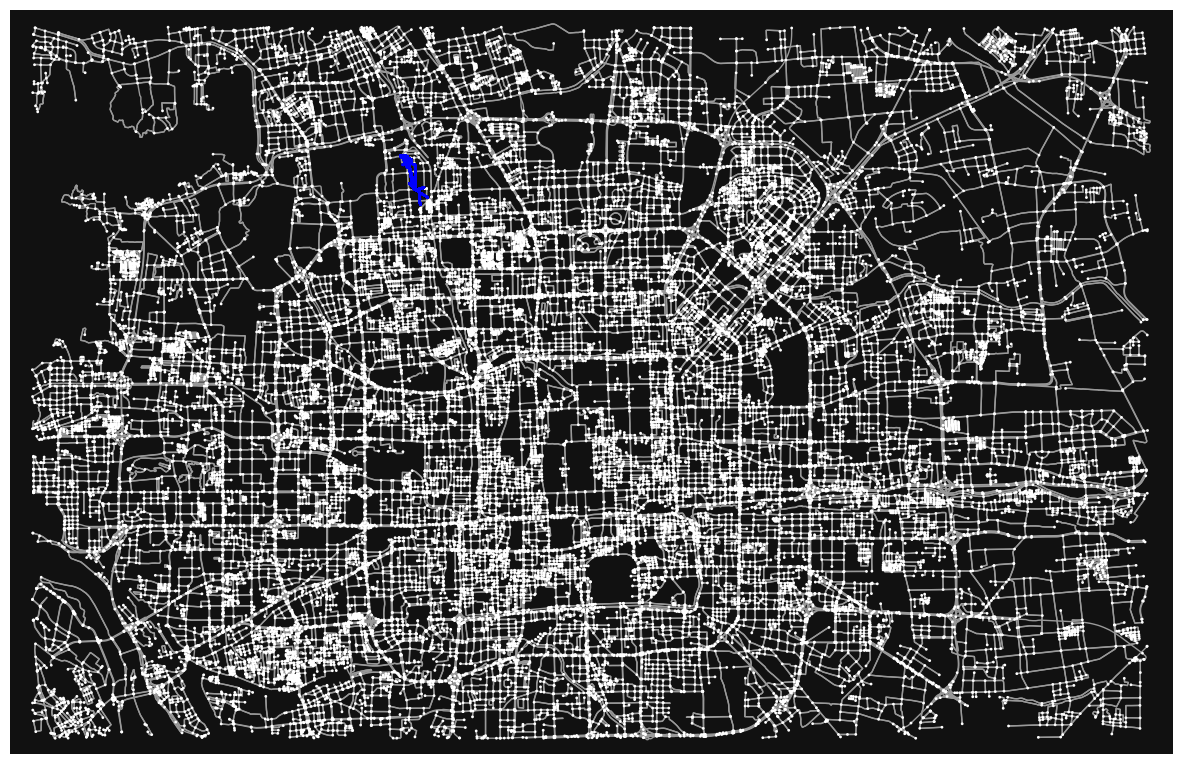

In [20]:
# Taking a single trajectory file and creating a gif
# Example: 000/Trajectory/20081112023003.plt
df = read_plt('../data/geolife/Data/000/Trajectory/20081112023003.plt')
fig, ax = ox.plot_graph(beijing_road, figsize=(15,15), show=False, close=False, node_size=4)
df = df.sort_values('timestamp')

# Make temporary directory
os.makedirs('../out/tmp', exist_ok=True)
for i in range(len(df)):
    ax.plot(df['lon'].values[:i], df['lat'].values[:i], color='blue', alpha=0.5)
    # plt.savefig(f'../out/tmp/20081112023003_{i}.png')

In [17]:
# Create gif
os.system('convert -delay 10 -loop 0 ../out/tmp/20081112023003_*.png ../out/20081112023003.gif')
os.system('rm -rf ../out/tmp')

convert-im6.q16: cache resources exhausted `../out/20081112023003.gif' @ error/cache.c/OpenPixelCache/4083.
convert-im6.q16: memory allocation failed `../out/20081112023003.gif' @ error/gif.c/WriteGIFImage/1690.


0

![](../out/20081112023003.gif)

### Example: Single Driver All Trajectories

Lenght of the data:  173870


/var/folders/xs/8ytvq8397bz3p0mp2cdjyd_40000gn/T/ipykernel_67049/1776159504.py:6: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  beijing_road = ox.graph_from_bbox(40.05, 39.83, 116.62, 116.17, network_type='drive')
/var/folders/xs/8ytvq8397bz3p0mp2cdjyd_40000gn/T/ipykernel_67049/1776159504.py:6: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  beijing_road = ox.graph_from_bbox(40.05, 39.83, 116.62, 116.17, network_type='drive')


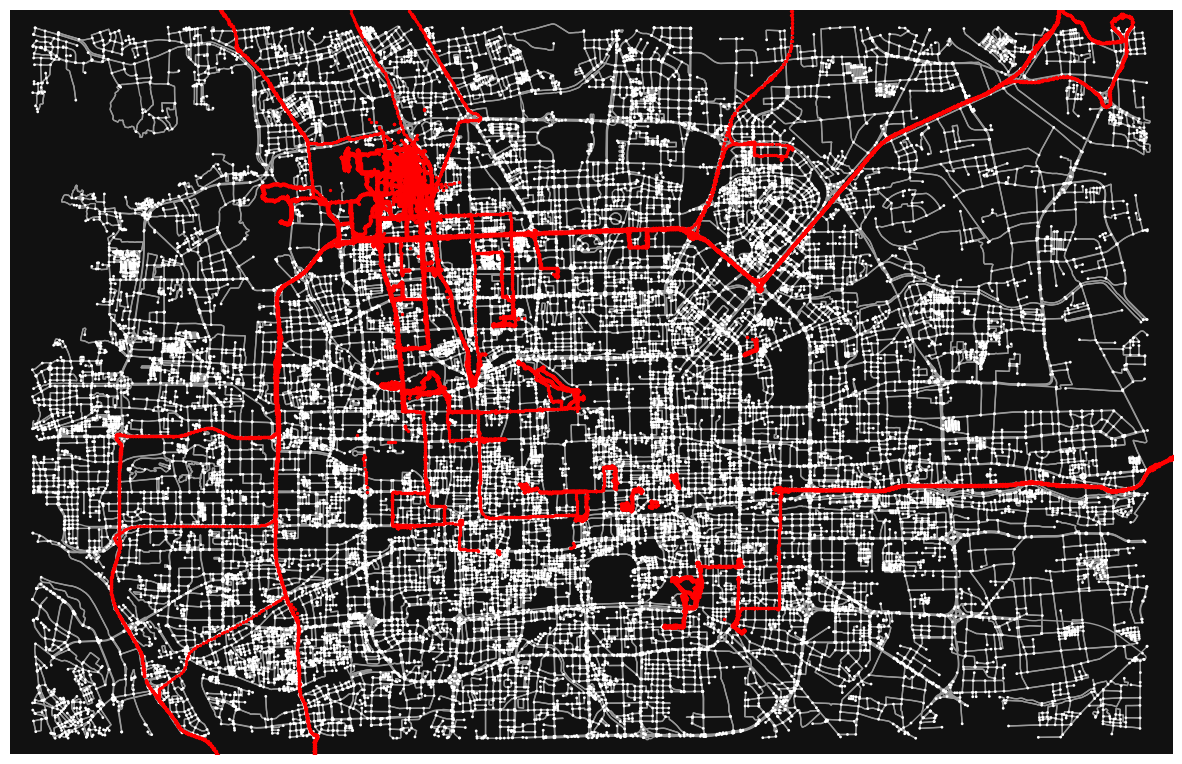

In [28]:
# Take a single driver for the example
df = read_all_plt_files()
print("Lenght of the data: ", len(df))

# OSM
beijing_road = ox.graph_from_bbox(40.05, 39.83, 116.62, 116.17, network_type='drive')
fig, ax = ox.plot_graph(beijing_road, figsize=(15,15), show=False, close=False, node_size=4)
ax.scatter(df['lon'], df['lat'], c='red', s=2)

plt.show()

### EDA
Let's perform the EDA on all trajectories

In [16]:
df = pd.read_pickle('../data/geolife.pkl')

In [17]:
print("Length of the data: ", len(df))
print("Number of drivers: ", len(df['driver_id'].unique()))
print("Number of trajectories: ", len(df['trajectory'].unique())) 

Length of the data:  24876978
Number of drivers:  182
Number of trajectories:  17784


Length of the data:  24876978

Number of drivers:  182

Number of trajectories:  17784

In [94]:
# Total duration in hours
# Group by driver_id and trajectory, then calculate the duration (difference between max and min timestamp)
grouped = df.groupby(['driver_id', 'trajectory']).agg(
    start_time=('timestamp', 'min'),
    end_time=('timestamp', 'max')
)
grouped['duration'] = (grouped['end_time'] - grouped['start_time']).dt.total_seconds()
grouped = grouped.reset_index() # Flatten the grouped DataFrame
print(grouped.drop(columns=['start_time', 'end_time']))

total_duration = grouped['duration'].sum() / 3600
print("Total duration in hours: ", total_duration) # Should be 50176.776666666665

# Distribution of trajectories by effective duration (>1hr, 1h-6hr, 6hr-12hr, >=12hr)
# Effective duration is the time difference between the first and last point in a trajectory
trajectory_duration = grouped

trajectory_duration['duration_hours'] = (trajectory_duration['end_time'] - trajectory_duration['start_time']).dt.total_seconds() / 3600
bins = [0, 1, 6, 12, float('inf')]  
labels = ['<1hr', '1h-6h', '6h-12h', '>=12h'] 
trajectory_duration['duration_category'] = pd.cut(trajectory_duration['duration_hours'], bins=bins, labels=labels, right=False)

# Calculate the total number of trajectories in each duration category
category_summary = trajectory_duration.groupby('duration_category').size().reset_index(name='count')

# Calculate the percentage of trajectories in each category
category_summary['percentage'] = (category_summary['count'] / category_summary['count'].sum()) * 100

dis_of_effective_duration = category_summary

      driver_id          trajectory  duration
0           000  20081023025304.plt   29888.0
1           000  20081024020959.plt    2227.0
2           000  20081026134407.plt    4800.0
3           000  20081027115449.plt     665.0
4           000  20081028003826.plt   15916.0
...         ...                 ...       ...
18665       181  20080128042855.plt    9940.0
18666       181  20080206025637.plt    3995.0
18667       181  20080216080442.plt    3324.0
18668       181  20080217010131.plt   35044.0
18669       181  20080314025755.plt    2745.0

[18670 rows x 3 columns]
Total duration in hours:  50176.776666666665


/var/folders/xs/8ytvq8397bz3p0mp2cdjyd_40000gn/T/ipykernel_67049/2665015879.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_summary = trajectory_duration.groupby('duration_category').size().reset_index(name='count')


In [85]:
# Total distance traveled by all drivers
# Calculate the distance between the consecutive points of each trajectory and sum them up

# Haversine function to calculate the distance between two points on Earth (rough estimate)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c  # Return distance in kilometers

# Sort the DataFrame by driver_id, trajectory, and timestamp to calculate distances in order
dist = df.sort_values(by=['driver_id', 'trajectory', 'timestamp'])

# Shift the lat/lon values by one row to calculate the distance between consecutive points
dist['lat_next'] = dist.groupby(['driver_id', 'trajectory'])['lat'].shift(-1)
dist['lon_next'] = dist.groupby(['driver_id', 'trajectory'])['lon'].shift(-1)

# Drop rows where next lat/lon is NaN (i.e., the last row in each trajectory)
dist = dist.dropna(subset=['lat_next', 'lon_next'])

# Calculate the distance for each row using the Haversine formula
dist['distance'] = haversine(dist['lat'], dist['lon'], dist['lat_next'], dist['lon_next'])

# Group by driver_id and trajectory, then sum the distances to get the total distance per trajectory
grouped = dist.groupby(['driver_id', 'trajectory']).agg(total_distance=('distance', 'sum')).reset_index()

print(grouped)

# Total distance traveled by all drivers
total_distance = grouped['total_distance'].sum()
print("Total distance traveled by all drivers: ", total_distance)

# Distribution of trajectories by distance (< 5KM, 5-20KM, 20-100KM, > 100KM)
bins = [0, 5, 20, 100, float('inf')]
labels = ['< 5KM', '5-20KM', '20-100KM', '> 100KM']
grouped['distance_category'] = pd.cut(grouped['total_distance'], bins=bins, labels=labels, right=False)
grouped_dist = grouped.groupby('distance_category').size().reset_index(name='count')
grouped_dist['percentage'] = grouped_dist['count'] / grouped_dist['count'].sum() * 100

dis_of_distance = grouped_dist


      driver_id          trajectory  total_distance
0           000  20081023025304.plt       14.938621
1           000  20081024020959.plt        1.303660
2           000  20081026134407.plt       18.648325
3           000  20081027115449.plt        1.895661
4           000  20081028003826.plt        8.598824
...         ...                 ...             ...
18665       181  20080128042855.plt       15.125359
18666       181  20080206025637.plt       12.298977
18667       181  20080216080442.plt        3.878869
18668       181  20080217010131.plt        5.687773
18669       181  20080314025755.plt        1.858782

[18670 rows x 3 columns]
Total distance traveled by all drivers:  1292668.1608387176


/var/folders/xs/8ytvq8397bz3p0mp2cdjyd_40000gn/T/ipykernel_67049/2341331040.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_dist = grouped.groupby('distance_category').size().reset_index(name='count')


The user guide (published by authors of the dataset) says 
> This dataset contains 17,621 trajectories with a total distance of 1,292,951kilometers and a total duration of 50,176 hours. 

I got 50,176 hours, 1,292,668.16 km, which is close enough.

In [73]:
# Distribution of the number of trajectories per user (<10, 10-50, 50-100, >=100)
trajectory_count = df.groupby('driver_id')['trajectory'].nunique().reset_index()
trajectory_count.columns = ['driver_id', 'trajectory_count']
bins = [0, 10, 50, 100, float('inf')]  # Define the bin edges
labels = ['<10', '10-50', '50-100', '>=100']  # Labels for each bin
trajectory_count['category'] = pd.cut(trajectory_count['trajectory_count'], bins=bins, labels=labels, right=False)
category_summary = trajectory_count.groupby('category').size().reset_index(name='count')
category_summary['percentage'] = (category_summary['count'] / category_summary['count'].sum()) * 100

dis_of_trajectories = category_summary

/var/folders/xs/8ytvq8397bz3p0mp2cdjyd_40000gn/T/ipykernel_67049/317206885.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_summary = trajectory_count.groupby('category').size().reset_index(name='count')


In [74]:
# Distribution of users by data collection period (1 week, 1 week to 1 month, 1 month to 1 year, > 1 year)
# Calculate the time span of data collection for each driver
time_span = df.groupby('driver_id').agg(
    start_time=('timestamp', 'min'),
    end_time=('timestamp', 'max')
)
time_span['duration'] = (time_span['end_time'] - time_span['start_time']).dt.days
time_span = time_span.drop(columns=['start_time', 'end_time'])
time_span = time_span.reset_index()

# Define the bins and labels for the time span categories
bins = [0, 7, 30, 365, float('inf')]
labels = ['< 1 week', '1 week to 1 month', '1 month to 1 year', '> 1 year']
time_span['category'] = pd.cut(time_span['duration'], bins=bins, labels=labels, right=False)
category_summary = time_span.groupby('category', observed=True).size().reset_index(name='count')
category_summary['percentage'] = (category_summary['count'] / category_summary['count'].sum()) * 100

dis_of_period = category_summary

Text(0.5, 1.0, 'Distribution of trajectories by effective duration')

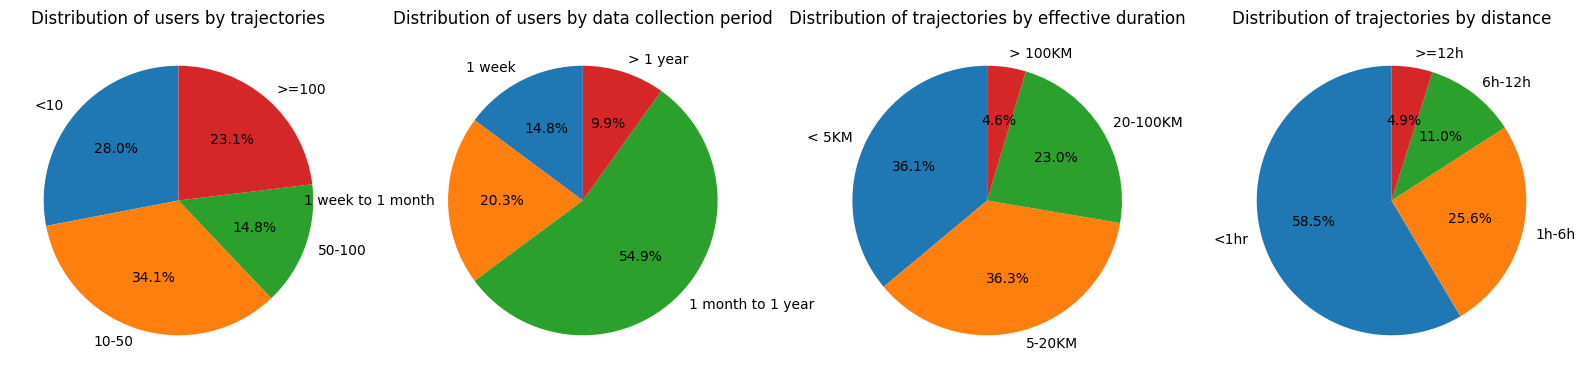

In [95]:
# Plotting
# Charts 1 x 4
fig, axes = plt.subplots(1, 4, figsize=(20, 10))

# Plot category_summary percentage as pie chart
axes[0].pie(dis_of_trajectories['percentage'], labels=dis_of_trajectories['category'], autopct='%1.1f%%', startangle=90)
axes[0].set_title('Distribution of users by trajectories')
axes[1].pie(dis_of_period['percentage'], labels=dis_of_period['category'], autopct='%1.1f%%', startangle=90)
axes[1].set_title('Distribution of users by data collection period')
axes[2].pie(dis_of_distance['percentage'], labels=dis_of_distance['distance_category'], autopct='%1.1f%%', startangle=90)
axes[3].set_title('Distribution of trajectories by distance')
axes[3].pie(dis_of_effective_duration['percentage'], labels=dis_of_effective_duration['duration_category'], autopct='%1.1f%%', startangle=90)
axes[2].set_title('Distribution of trajectories by effective duration')

Aside from the second chart (which has some discrepency with the data collection period), we get the same EDA pie charts with the guide.

![geolife_eda](../imgs/geolife_eda1.png)

Let's try to understand transportation modes and try to replicate the statistics provided the guide.

In [18]:
print("Users with labels: ", len(df['driver_id'].unique()))
print("Unique transport modes: ", df['transport_mode'].unique())

# Sort the DataFrame by driver_id, trajectory, transportation_mode, and timestamp to calculate durations in order
df = df.sort_values(by=['driver_id', 'trajectory', 'transport_mode', 'timestamp'])

# Group by driver_id, trajectory, and transportation_mode to find the start and end time of each segment
duration_by_mode = df.groupby(['driver_id', 'trajectory', 'transport_mode']).agg(
    start_time=('timestamp', 'min'),
    end_time=('timestamp', 'max')
).reset_index()

# Calculate the duration for each transportation mode (in seconds)
duration_by_mode['duration_seconds'] = (duration_by_mode['end_time'] - duration_by_mode['start_time']).dt.total_seconds()
duration_by_mode['duration_hours'] = duration_by_mode['duration_seconds'] / 3600

# Group by transportation_mode and calculate the total duration for each mode
duration_by_mode = duration_by_mode.groupby('transport_mode').agg(total_duration=('duration_seconds', 'sum')).reset_index()
duration_by_mode['total_duration_hours'] = duration_by_mode['total_duration'] / 3600

# Display the result
# print(duration_by_mode)

# 'car' and 'taxi' are the same transportation mode, so we will combine them
# 'other' contains 'motorcycle', 'run', 'subway', and 'boat'

# Combine 'car' and 'taxi' into 'car_taxi' and find sum of durations
duration_by_mode['transport_mode'] = duration_by_mode['transport_mode'].replace({'taxi': 'car'})
duration_by_mode = duration_by_mode.groupby('transport_mode').agg(total_duration=('total_duration', 'sum')).reset_index()
duration_by_mode['total_duration_hours'] = duration_by_mode['total_duration'] / 3600

# Combine 'motorcycle', 'run', 'subway', and 'boat' into 'other' and find sum of durations
duration_by_mode['transport_mode'] = duration_by_mode['transport_mode'].replace({'motorcycle': 'other', 'run': 'other', 'subway': 'other', 'boat': 'other'})
duration_by_mode = duration_by_mode.groupby('transport_mode').agg(total_duration=('total_duration', 'sum')).reset_index()
duration_by_mode['total_duration_hours'] = duration_by_mode['total_duration'] / 3600

print(duration_by_mode)

Users with labels:  182
Unique transport modes:  [0 'train' 'taxi' 'walk' 'bus' 'subway' 'airplane' 'car' 'bike' 'boat'
 'run' 'motorcycle']
  transport_mode  total_duration  total_duration_hours
0              0     169596124.0          47110.034444
1       airplane        121740.0             33.816667
2           bike       6497289.0           1804.802500
3            bus       8996693.0           2499.081389
4            car       5584858.0           1551.349444
5          other       1740703.0            483.528611
6          train       1774365.0            492.879167
7           walk      14444276.0           4012.298889


Let's visualize the lat-lon coordiantes.

In [19]:
# Plotting the lat-lon points with altitude as the color
# Keep points within the bounding box of Beijing (40.05, 39.83, 116.62, 116.17)
beijing_df = df[(df['lat'] >= 39.83) & (df['lat'] <= 40.05) & (df['lon'] >= 116.17) & (df['lon'] <= 116.62)]

# # Create a heatmap of the points
# fig = folium.Figure(width=800, height=800)
# m = folium.Map(location=[39.916, 116.397], zoom_start=12).add_to(fig)
# HeatMap(beijing_df[['lat', 'lon', 'alt']], radius=10).add_to(m)
# m.save('../out/heatmap.html')

# Show the map
m


### Mobility Characteristics


- Trip Length
- Trip Distance

### Spatial Heatmaps
Heatmaps can help us decipher GPS density. We can look at
1. Random Sample?
2. Part of Day (AM / PM)

In [ ]:
# Heatmap of trajectories that occur in the day
# Filter the data to include only trajectories that occur between 6 AM and 6 PM
day_trajectories = df[(df['timestamp'].dt.hour >= 6) & (df['timestamp'].dt.hour < 18)]
beijing_folium = folium.Map(location=[39.9, 116.4], zoom_start=12)
hm = HeatMap(data=df[['lat', 'lon']], radius=8).add_to(beijing_folium)
hm.save("../out/heatmap.html")


# Heatmap of trajectories that occur in the night
# Filter the data to include only trajectories that occur between 6 PM and 6 AM


## Privacy Preserving
